# Change Detection in portuguese soil using sequences of satellite images

Import some python modules and enable inline graphics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import randint
%matplotlib inline

## Obtain Data from Google Earth Engine

Initialize Google Earth Engine API

In [ ]:
import ee

# trigger the authentication flow
ee.Authenticate()

# initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=5OBo9_lFH4JR9ooKnZhYndrbFw3gXOgt2SmHtmFL2SI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g59Ej9pB0le0S-TjZe5oC_2Nf2kdSQTexFX1cCkhdxr3z1iorsds_w

Successfully saved authorization token.


Define the region of interest with GeoJSON

In [ ]:
coords = [-8.49606, 41.49750, -8.36868, 41.59050]

geoJSON = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": coords
    }
}

aoi = ee.Geometry.Rectangle(coords)

Get the image collection from the Google Earth Engine archives

In [ ]:
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')                      # specify image archive
                .filterBounds(aoi)                                         # specify area on interest
                .filterDate(ee.Date('2014-01-01'),ee.Date('2021-01-01'))   # specify time period
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # specify orbit pass 
                .sort('system:time_start'))                                # sort by date

### Data Manipulation

Get collection as a list and clip all images to the area of interest

In [ ]:
# get the image collection as a list
images = collection.toList(collection.size())

print('Number of images available:', images.length().getInfo())

# clip an image to the area of interest
def clip_image(image):
  return ee.Image(image).clip(aoi)

# clip all images to the area of interest
images = ee.List(images.map(clip_image))

Create a RGB composite from the diferent bands. For Sentinel-1 data, the standard way to make the RGB composite is VV for red, VH for green and VV/VH for blue

In [ ]:
def to_rgb(image):
  return ee.Image.rgb(image.select('VV'),                            
                      image.select('VH'),                            
                      image.select('VV').divide(image.select('VH')))

Convert a Earth Engine Image into a Pillow Image

In [ ]:
import requests

def to_pillow(image):
  url = image.getThumbURL({'min': [-20, -20, 0], 'max': [0, 0, 2]})
  return Image.open(requests.get(url, stream=True).raw)

Crop the center of an image

In [ ]:
def crop_image(image, new_width, new_height):
  image_width, image_height = image.size
  left = round((image_width - new_width)/2)
  top = round((image_height - new_height)/2)
  x_right = round(image_width - new_width) - left
  x_bottom = round(image_height - new_height) - top
  right = image_width - x_right
  bottom = image_height - x_bottom
  return image.crop((left, top, right, bottom))

Convert a Pillow Image into a Numpy Array

In [ ]:
def to_array(image):
  data = np.array(image)
  return data[:, :, 0]

Prepare data

In [ ]:
from tqdm import tqdm

def prepare_data(images):
  nr_images = images.length().getInfo()
  data = []
  #for i in range(nr_images):
  for i in tqdm(range(nr_images)):
  #for i in range(10):
    image = ee.Image(images.get(i))
    image_rgb = to_rgb(image)
    image_pillow = to_pillow(image_rgb)
    image_cropped = crop_image(image_pillow, 1024, 1024)
    image_data = to_array(image_cropped)
    data.append(image_data)
  return np.array(data)

data = prepare_data(images)

data = data.astype(np.int16)

print(data.shape)

Save images data to file

In [ ]:
def store_array(data, filename):
  np.save(filename + '.npy', data)

store_array(data, 'images')

## Obtain Data from File

Load images data from file in Google Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

def load_array(filename):
  return np.load(filename)

data = load_array('drive/MyDrive/Sentinel-1/images.npy')

Mounted at /content/drive


## Data Manipulation

Create set to make the problem supervised

In [3]:
def to_supervised(data, threshold):
  nr_images = np.size(data, 0)
  height = np.size(data, 1)
  width = np.size(data, 2)
  changes = np.empty((nr_images - 1, height, width))
  for i in range(nr_images - 1):
    ratio = np.subtract(data[i], data[i + 1])
    abs = np.absolute(ratio)
    abs[abs < threshold] = 0  # set pixels with value < threshold to 0 
    abs[abs >= threshold] = 1 # set pixels with value >= threshold to 1 
    changes[i] = abs
  return changes

changes = to_supervised(data, 50)

print(changes.shape)

(312, 1024, 1024)


Separate pairs of images to detect changes

In [4]:
def get_pairs(array):
  new_array = []
  for i in range(array.shape[0] - 1):
    pair = [array[i], array[i + 1]]
    new_array.append(pair)
    pairs = np.array(new_array)
  return pairs

data_pairs = get_pairs(data)
del data

print(data_pairs.shape)

(312, 2, 1024, 1024)


Slice an array into smaller arrays

In [5]:
def slice_array(array, width, height):
  slices = []
  for x in range(0, array.shape[0], height):
    for y in range(0, array.shape[1], width):
      slices.append(array[x: x + height, y: y + width])
  return np.array(slices)

Method to slice and group the data array into the shape:

(number of pairs, number of slices per pair, number of arrays per pair, slice width, slice height)

> data_slices[0][0][0] corresponds to the first slice of the first pair

In [6]:
image_size = 128

def slice_data(data):
  slices = []
  for pair in data:
    slices1 = slice_array(pair[0], image_size, image_size) # slices of the first array of the pair
    slices2 = slice_array(pair[1], image_size, image_size) # slices of the second array of the pair
    grouped_slices = [] # list with the slices of the pair grouped
    for s in range(len(slices1)):
      grouped_slices.append([slices1[s], slices2[s]])
    slices.append(grouped_slices)
  return np.array(slices)

data_slices = slice_data(data_pairs)
del data_pairs

print(data_slices.shape)

(312, 64, 2, 128, 128)


Method to slice the changes array into the shape: 

(number of changes, number of slices, slice width, slice height)

> changes_slices[0][0] corresponds to the first changes slice of the first pair 

In [7]:
def slice_changes(changes):
  slices = []
  for array in changes:
    slices.append(slice_array(array, image_size, image_size))
  return np.array(slices)

changes_slices = slice_changes(changes)
del changes

print(changes_slices.shape)

(312, 64, 128, 128)


Reshape the arrays

In [8]:
x = data_slices.reshape(-1, *data_slices.shape[-3:])
y = changes_slices.reshape(-1, *changes_slices.shape[-2:])
del data_slices
del changes_slices

print(x.shape)
print(y.shape)

(19968, 2, 128, 128)
(19968, 128, 128)


Normalize pixel values. The images are in gray scale, so the values are between [0, 255]

In [9]:
def normalize_data(data):
  return data.astype('float32') / 255

def denormalize_data(data):
  return data.astype('float32') * 255

Convert a Numpy Array into a Pilow Image

In [10]:
def to_image(array):
  image = Image.fromarray(array)
  if image.mode != 'RGB':
    image = image.convert('RGB')
  return image

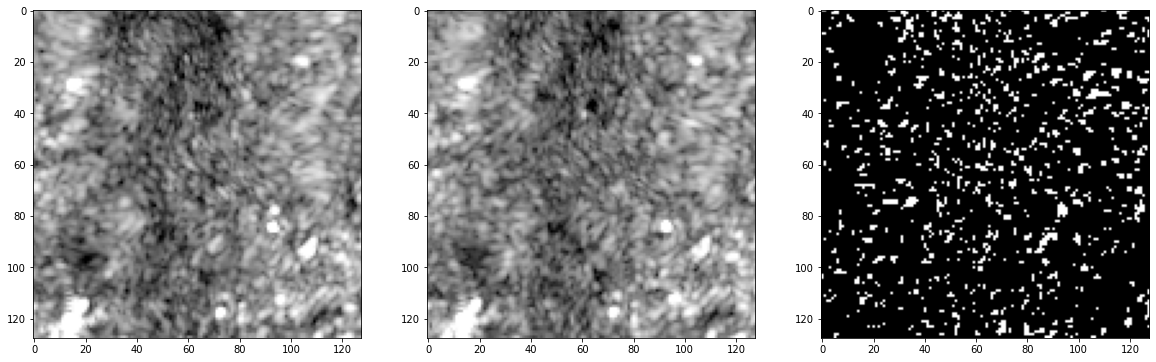

In [11]:
# choose random data from test dataset
n = randint(0, x.shape[0] - 1)
image1 = to_image(x[n][0])
image2 = to_image(x[n][1])
changes1 = to_image(denormalize_data(y[n]))

# display images
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(changes1)

In [12]:
x_normalized = normalize_data(x)
del x

In [13]:
new_x = []
for pair in x_normalized:
  new_x.append(np.stack((pair[0], pair[1]), axis=-1))
x_normalized = np.array(new_x)
del new_x

Split data into training and testing sets

In [14]:
import math

def split_data(data, changes, percentage):
  nr_images, _, _, _ = data.shape
  train_size = math.floor(nr_images * percentage)
  x_train, x_test = data[:train_size,:], data[train_size:,:]
  y_train, y_test = changes[:train_size,:], changes[train_size:,:]
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(x_normalized, y, 0.9)
x_train, y_train, x_val, y_val = split_data(x_train, y_train, 0.8)
del x_normalized
del y

print('Training data set shape:', x_train.shape)
print('Training changes set shape:', y_train.shape)
print('Validation data set shape:', x_val.shape)
print('Validation changes set shape:', y_val.shape)
print('Testing data set shape:', x_test.shape)
print('Testing changes set shape:', y_test.shape)

Training data set shape: (14376, 128, 128, 2)
Training changes set shape: (14376, 128, 128)
Validation data set shape: (3595, 128, 128, 2)
Validation changes set shape: (3595, 128, 128)
Testing data set shape: (1997, 128, 128, 2)
Testing changes set shape: (1997, 128, 128)


## U-Net

In [15]:
import tensorflow as tf

# for replicability purposes
tf.random.set_seed(91195003) 
np.random.seed(91190530)
# for an easy reset backend session state 
tf.keras.backend.clear_session()

Define U-Net layer blocks

In [16]:
# contraction block
def down_block(x, filters):
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(c)
    mp = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, mp

# expansion block
def up_block(x, skip, filters):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(c)
    return c

# bottleneck block
def bottleneck(x, filters):
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', strides=1, activation="relu")(c)
    return c

Build U-Net model

In [17]:
def UNet():
    # input layer
    inputs = tf.keras.layers.Input((image_size, image_size, 2))

    # contraction network (encoder)
    c1, mp1 = down_block(inputs, 16) # 128x128x2 -> 64x64x16 
    c2, mp2 = down_block(mp1, 32)    # 64x64x16 -> 32x32x32
    c3, mp3 = down_block(mp2, 64)    # 32x32x32 -> 16x16x64
    c4, mp4 = down_block(mp3, 128)   # 16x16x64 -> 8x8x128
    
    # bottleneck
    bn = bottleneck(mp4, 256) # 8x8x128 -> 8x8x256

    # expansion network (decoder)
    u1 = up_block(bn, c4, 128) # 8x8x256 -> 16x16x128
    u2 = up_block(u1, c3, 64)  # 16x16x128 -> 32x32x64
    u3 = up_block(u2, c2, 32)  # 32x32x64 -> 64x64x32
    u4 = up_block(u3, c1, 16)  # 64x64x32 -> 128x128x16

    # final layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u4) # 128x128x16 -> 128x128x1

    model = tf.keras.models.Model(inputs, outputs)
    return model

In [18]:
model = UNet()
#model.summary()

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),                                                                                 
          epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
450/450 [==============================] - 72s 84ms/step - loss: 0.2361 - accuracy: 0.9101 - val_loss: 0.1055 - val_accuracy: 0.9582
Epoch 2/10
450/450 [==============================] - 37s 81ms/step - loss: 0.0722 - accuracy: 0.9710 - val_loss: 0.0494 - val_accuracy: 0.9808
Epoch 3/10
450/450 [==============================] - 37s 82ms/step - loss: 0.0400 - accuracy: 0.9843 - val_loss: 0.0373 - val_accuracy: 0.9837
Epoch 4/10
450/450 [==============================] - 38s 84ms/step - loss: 0.0283 - accuracy: 0.9891 - val_loss: 0.0251 - val_accuracy: 0.9906
Epoch 5/10
450/450 [==============================] - 38s 84ms/step - loss: 0.0225 - accuracy: 0.9916 - val_loss: 0.0250 - val_accuracy: 0.9887
Epoch 6/10
450/450 [==============================] - 38s 84ms/step - loss: 0.0191 - accuracy: 0.9930 - val_loss: 0.0170 - val_accuracy: 0.9941
Epoch 7/10
450/450 [==============================] - 38s 84ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 0.0151 - val_accuracy:

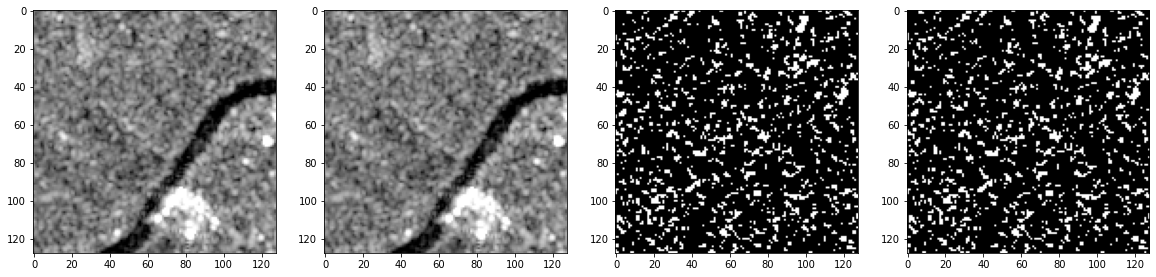

In [39]:
# choose random data from test dataset
n = randint(0, x_test.shape[0] - 1)

# predict changes
input_data = x_test[n].reshape(-1, image_size, image_size, 2)
prediction = model.predict(input_data)

# process prediction to an image
prediction = prediction > 0.5
prediction = prediction.reshape(image_size, image_size)
data_pred = denormalize_data(prediction)
prediction_image = to_image(data_pred)

# process input data and real changes to images
image1 = to_image(denormalize_data(x_test[n].T[0]))
image2 = to_image(denormalize_data(x_test[n].T[1]))
truth_image = to_image(denormalize_data(y_test[n]))

# display images
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(image1)
ax[1].imshow(image1)
ax[2].imshow(truth_image)
ax[3].imshow(prediction_image)

In [34]:
# save images
'''
image1.save('image1.png')
image2.save('image2.png')
truth_image.save('truth.png')
prediction_image.save('prediction.png')
'''

## References

https://arxiv.org/pdf/1812.05815.pdf

https://github.com/annabosman/UNet-based-Unsupervised-Change-Detection/blob/master/Unet.py

http://mtc-m21c.sid.inpe.br/col/sid.inpe.br/mtc-m21c/2020/06.09.11.59/doc/publicacao.pdf

https://www.researchgate.net/profile/Roberto-Arroyo-4/publication/304533064_Street-View_Change_Detection_with_Deconvolutional_Networks/links/5773858508ae6f328f6c29e4/Street-View-Change-Detection-with-Deconvolutional-Networks.pdf

https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiWjteOpfDwAhWE3OAKHVtSDLU4ChAWegQIDRAA&url=https%3A%2F%2Fawesomeopensource.com%2Fproject%2Frobmarkcole%2Fsatellite-image-deep-learning&usg=AOvVaw0xkih02QdQcpSUsuxb6Ba0